In [1]:
import time, matplotlib, sklearn

# visualizatoin 
import matplotlib.pyplot as plt 

# data wrangling
import pandas as pd
import numpy as np

# data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer

# learning
from sklearn.linear_model import LogisticRegression

# the data intro has been tested with the following versions
print("pandas        Tested version: 2.0.3   Your version: %s" % pd.__version__)
print("numpy         Tested version: 1.21.5  Your version: %s" % np.__version__)
print("matplotlib    Tested version: 3.5.3   Your version: %s" % matplotlib.__version__)
print("scikit-learn  Tested version: 1.2.2   Your version: %s" % sklearn.__version__)

pandas        Tested version: 2.0.3   Your version: 2.2.3
numpy         Tested version: 1.21.5  Your version: 2.1.3
matplotlib    Tested version: 3.5.3   Your version: 3.10.0
scikit-learn  Tested version: 1.2.2   Your version: 1.6.1


# Fetching proprocessed data

In [3]:
X_test = pd.read_csv('preprocessed_data/X_test.csv')
X_train = pd.read_csv('preprocessed_data/X_train.csv')
X_val = pd.read_csv('preprocessed_data/X_val.csv')
y_apache_test = np.ravel(pd.read_csv('preprocessed_data/y_apache_test.csv'))
y_test = np.ravel(pd.read_csv('preprocessed_data/y_test.csv'))
y_train = np.ravel(pd.read_csv('preprocessed_data/y_train.csv'))
y_val = np.ravel(pd.read_csv('preprocessed_data/y_val.csv'))

# Imports

## Decision tree

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from fairlearn.metrics import false_negative_rate, false_positive_rate,true_positive_rate, true_negative_rate
from sklearn.metrics import confusion_matrix

dt = DecisionTreeClassifier()

dt.fit(X_train, y_train)

y_pred = dt.predict(X_val)

acc = accuracy_score(y_val, y_pred)
class_rep = classification_report(y_val, y_pred)

print(f"Accuracy: {acc:.2f}")
print("\nClassification Report:\n", class_rep)
print("False negative rate: ", false_negative_rate(y_val, y_pred))
print("False positive rate: ", false_positive_rate(y_val, y_pred))
print("True negative rate: ", true_negative_rate(y_val, y_pred))
print("True positive rate: ", true_positive_rate(y_val, y_pred))

# y_pred are our model's predictions
display(confusion_matrix(y_val, y_pred))

pd.Series(dt.feature_importances_, list(X_train)).sort_values(ascending=False)


Accuracy: 0.77

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.84      0.85      9128
           1       0.46      0.52      0.49      2471

    accuracy                           0.77     11599
   macro avg       0.66      0.68      0.67     11599
weighted avg       0.78      0.77      0.77     11599

False negative rate:  0.4848239579117766
False positive rate:  0.16213847502191062
True negative rate:  0.8378615249780894
True positive rate:  0.5151760420882234


array([[7648, 1480],
       [1198, 1273]])

num__gcs_motor_apache            0.104648
num__d1_lactate_max              0.045774
num__d1_sysbp_noninvasive_min    0.038357
num__apache_3j_diagnosis         0.029606
num__d1_bun_min                  0.019315
                                   ...   
num__intubated_apache            0.000000
num__readmission_status          0.000000
num__aids                        0.000000
num__hepatic_failure             0.000000
num__leukemia                    0.000000
Length: 185, dtype: float64

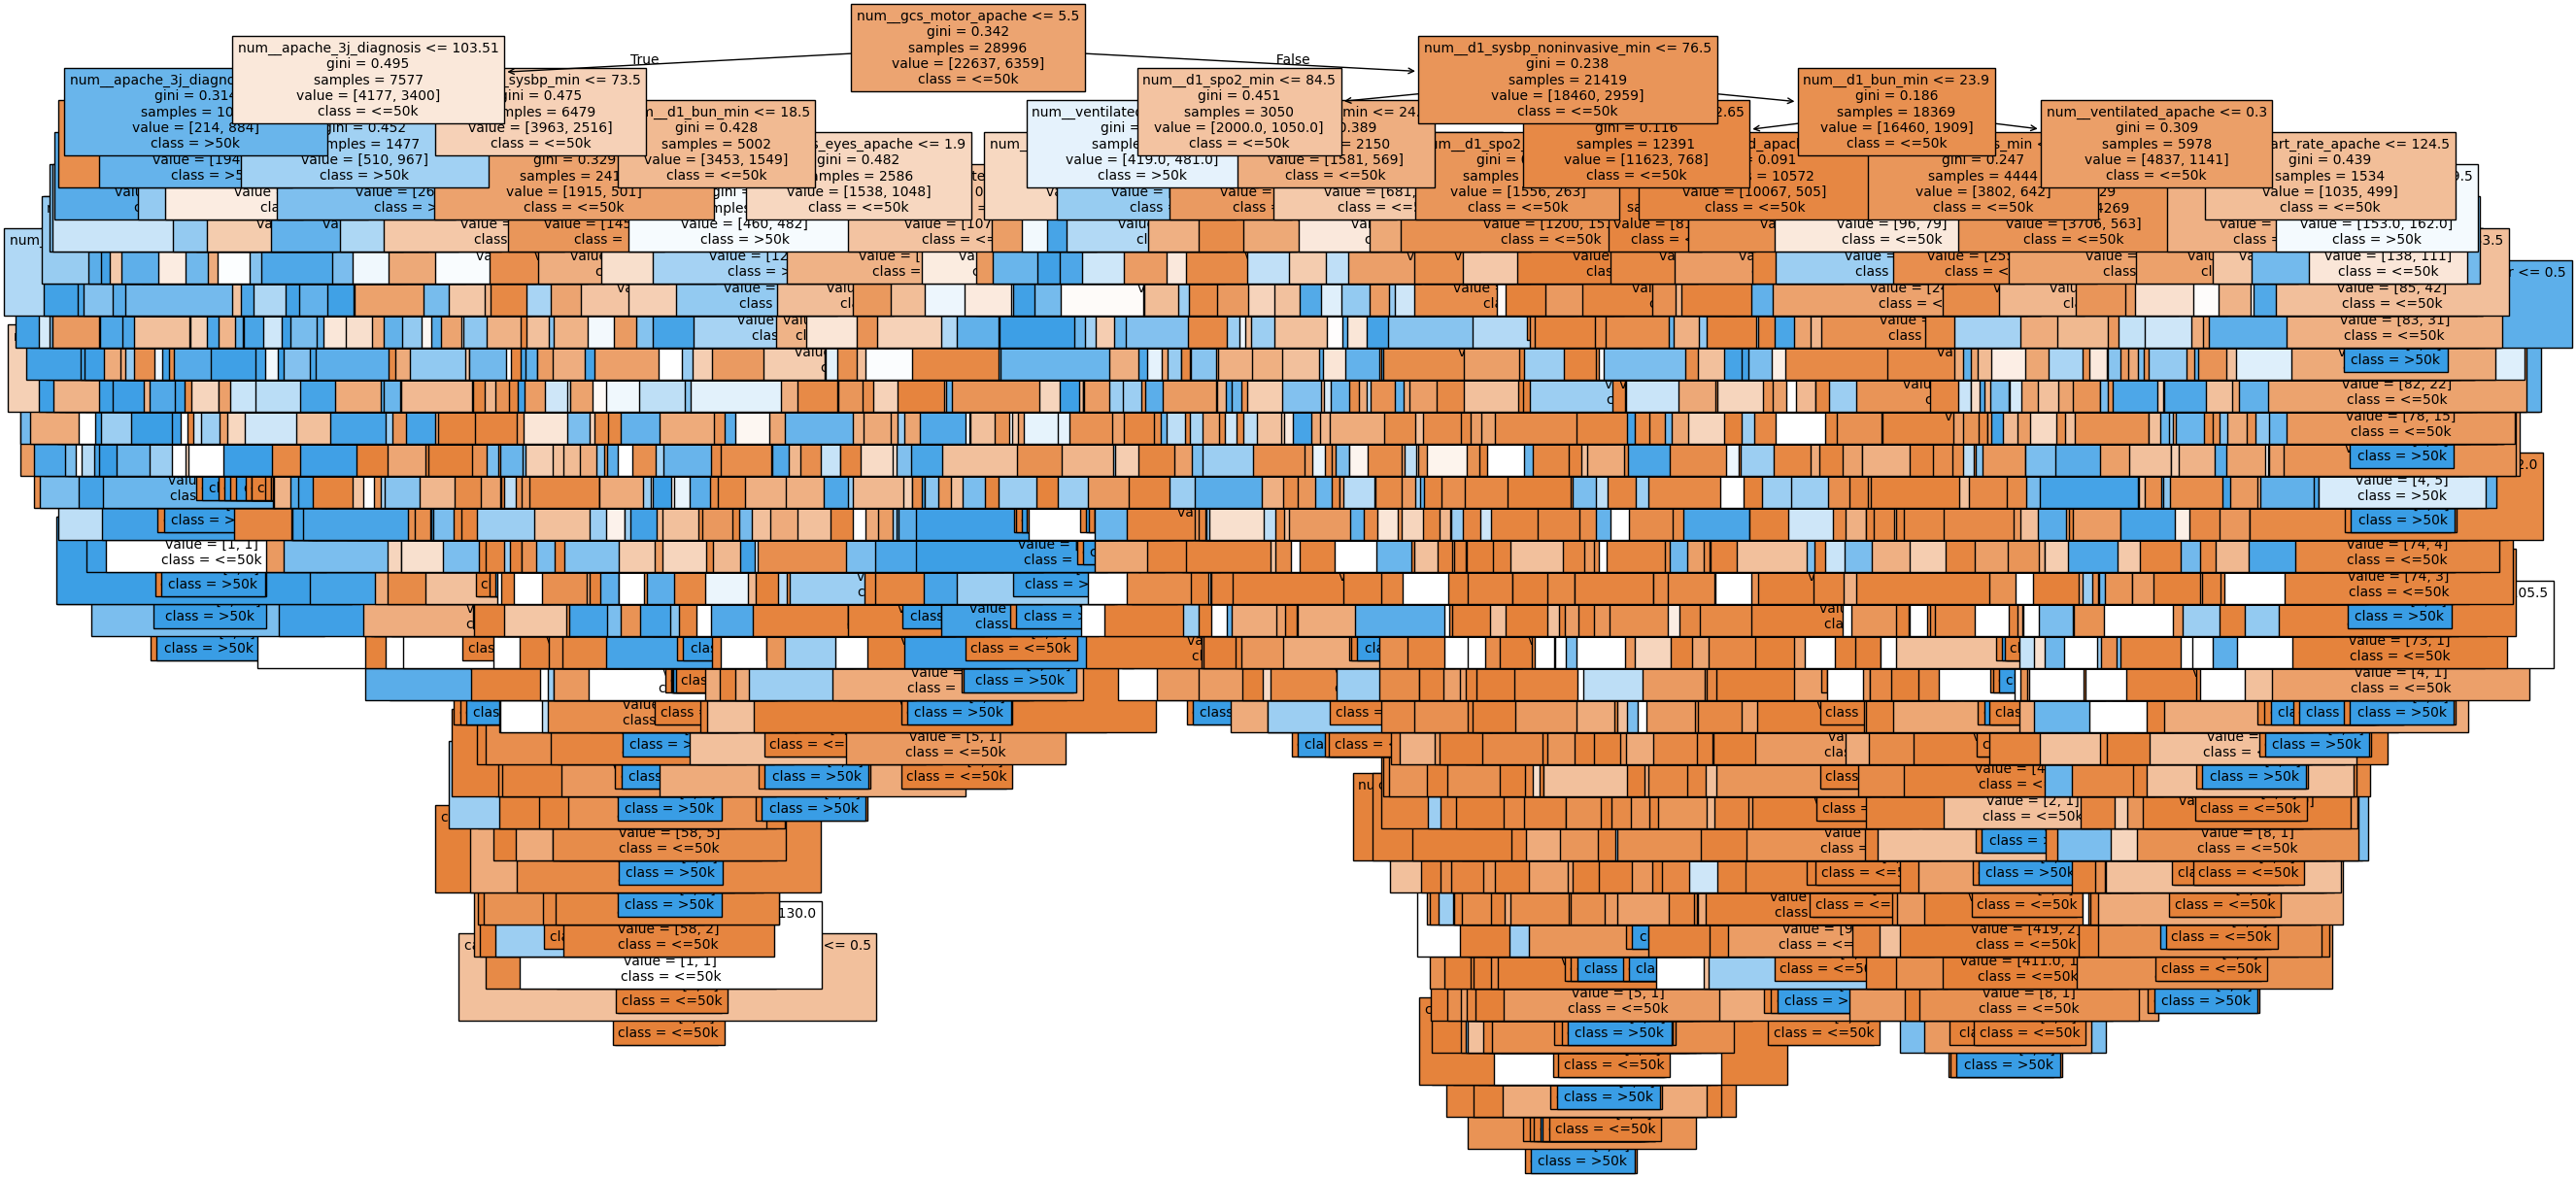

In [70]:
fig = plt.figure(figsize=(30, 15))
fig = plot_tree(
    dt,
    fontsize=10,
    feature_names=list(X_train),
    class_names=["<=50k", ">50k"],
    filled=True,
)
plt.show()

## Random forest test

- Predict `hospital_death`
- Should be both accurate and interpretability
- Handles missing data 
- Should be good at complex data

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy=1.0, random_state=42)  # Make positive class equal to negative class
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

In [8]:
start_time = time.time()

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


# Intialize classifier 
rf = RandomForestClassifier(
    n_estimators=500,  # More trees for stability
    max_depth=20,  # Prevent overfitting to majority class
    min_samples_leaf=5,  # Avoid tiny splits that favor majority
    class_weight={0:1, 1:3}
    )

# Fit classifier
rf.fit(X_train_bal, y_train_bal)

# Predict
y_pred = rf.predict(X_val)

# Calculate metrics
acc = accuracy_score(y_val, y_pred)
class_rep = classification_report(y_val, y_pred)

# Print results
print("Time: %.2fs" % (time.time() - start_time))

Time: 89.88s


In [11]:
from fairlearn.metrics import false_negative_rate, false_positive_rate,true_positive_rate, true_negative_rate
from sklearn.metrics import confusion_matrix, roc_curve

# y_pred = rf_calibrated.predict(X_test)
y_pred = rf.predict(X_val)
y_score = rf.predict_proba(X_val)[:, 1]


fpr, tpr, thresholds = roc_curve(y_val, y_score)
youden_index = tpr - fpr
optimal_threshold = thresholds[np.argmax(youden_index)]
print(f"Optimal Threshold (ROC-based): {optimal_threshold}")

def custom_f1(y_true, y_pred, beta=2):  # Adjust beta for recall emphasis
    from sklearn.metrics import fbeta_score
    return fbeta_score(y_true, y_pred, beta=beta)

best_threshold = max(thresholds, key=lambda t: custom_f1(y_val, (y_score >= t).astype(int)))
print(f"Best Cost-Sensitive Threshold: {best_threshold}")

y_pred = (y_score >= optimal_threshold).astype(int)



print(f"Accuracy: {acc:.2f}")
print("\nClassification Report:\n", class_rep)
print("False negative rate: ", false_negative_rate(y_val, y_pred))
print("False positive rate: ", false_positive_rate(y_val, y_pred))
print("True negative rate: ", true_negative_rate(y_val, y_pred))
print("True positive rate: ", true_positive_rate(y_val, y_pred))


# y_pred are our model's predictions
display(confusion_matrix(y_val, y_pred))


# # Sample prediction
# sample = X_test.iloc[0:1]  # Keep as DataFrame to match model input format
# prediction = rf_balanced.predict(sample)

Optimal Threshold (ROC-based): 0.4041791774461259
Best Cost-Sensitive Threshold: 0.3506817069178681
Accuracy: 0.82

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.84      0.88      9128
           1       0.55      0.74      0.63      2471

    accuracy                           0.82     11599
   macro avg       0.74      0.79      0.75     11599
weighted avg       0.84      0.82      0.82     11599

False negative rate:  0.1529745042492918
False positive rate:  0.2567922874671341
True negative rate:  0.7432077125328659
True positive rate:  0.8470254957507082


array([[6784, 2344],
       [ 378, 2093]])

In [144]:
pd.Series(rf.feature_importances_, list(X_train)).sort_values(ascending=False)

num__ventilated_apache                          0.062949
num__gcs_verbal_apache                          0.061339
num__gcs_motor_apache                           0.049564
num__gcs_eyes_apache                            0.037111
num__d1_bun_max                                 0.026280
                                                  ...   
cat__hospital_admit_source_Chest Pain Center    0.000000
cat__hospital_admit_source_ICU to SDU           0.000000
cat__hospital_admit_source_Observation          0.000000
num__readmission_status                         0.000000
num__aids                                       0.000000
Length: 185, dtype: float64

In [99]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# predictions
rf_y_pred_train = rf.predict(X_train)
rf_y_pred_val = rf.predict(X_val)

# train surrogate model
dt = DecisionTreeClassifier(max_depth=4)
dt.fit(
    X_train, rf_y_pred_train
)  # we train a very simple decision tree classifier based on the random forest classifier

y_dt_train = dt.predict(X_train)
y_dt_val = dt.predict(X_val)

# compute fidelity
print("\nFidelity")
print(
    "tpr (train) : %.2f \ntnr (train) : %.2f"
    % (
        true_positive_rate(rf_y_pred_train, y_dt_train),
        true_negative_rate(rf_y_pred_train, y_dt_train),
    )
)
print(
    "tpr (test)  : %.2f \ntnr (test)  : %.2f"
    % (
        true_positive_rate(rf_y_pred_val, y_dt_val),
        true_negative_rate(rf_y_pred_val, y_dt_val),
    )
)

# compute predictive performance
print("\nPredictive Performance")
print(
    "tpr (train) : %.2f \ntnr (train) : %.2f"
    % (true_positive_rate(y_train, y_dt_train), true_negative_rate(y_train, y_dt_train))
)
print(
    "tpr (test)  : %.2f \ntnr (test)  : %.2f"
    % (true_positive_rate(y_val, y_dt_val), true_negative_rate(y_val, y_dt_val))
)


Fidelity
tpr (train) : 0.50 
tnr (train) : 0.97
tpr (test)  : 0.53 
tnr (test)  : 0.99

Predictive Performance
tpr (train) : 0.45 
tnr (train) : 0.93
tpr (test)  : 0.45 
tnr (test)  : 0.92


In [100]:
pd.Series(dt.feature_importances_, list(X_train)).sort_values(ascending=False).head(10)

num__gcs_motor_apache              0.469313
num__d1_bun_max                    0.157573
num__ventilated_apache             0.117605
num__d1_sysbp_noninvasive_min      0.104041
num__apache_3j_diagnosis           0.071834
num__d1_sysbp_min                  0.033243
num__d1_creatinine_min             0.017859
num__d1_temp_min                   0.014718
num__bun_apache                    0.013814
cat__ethnicity_African American    0.000000
dtype: float64

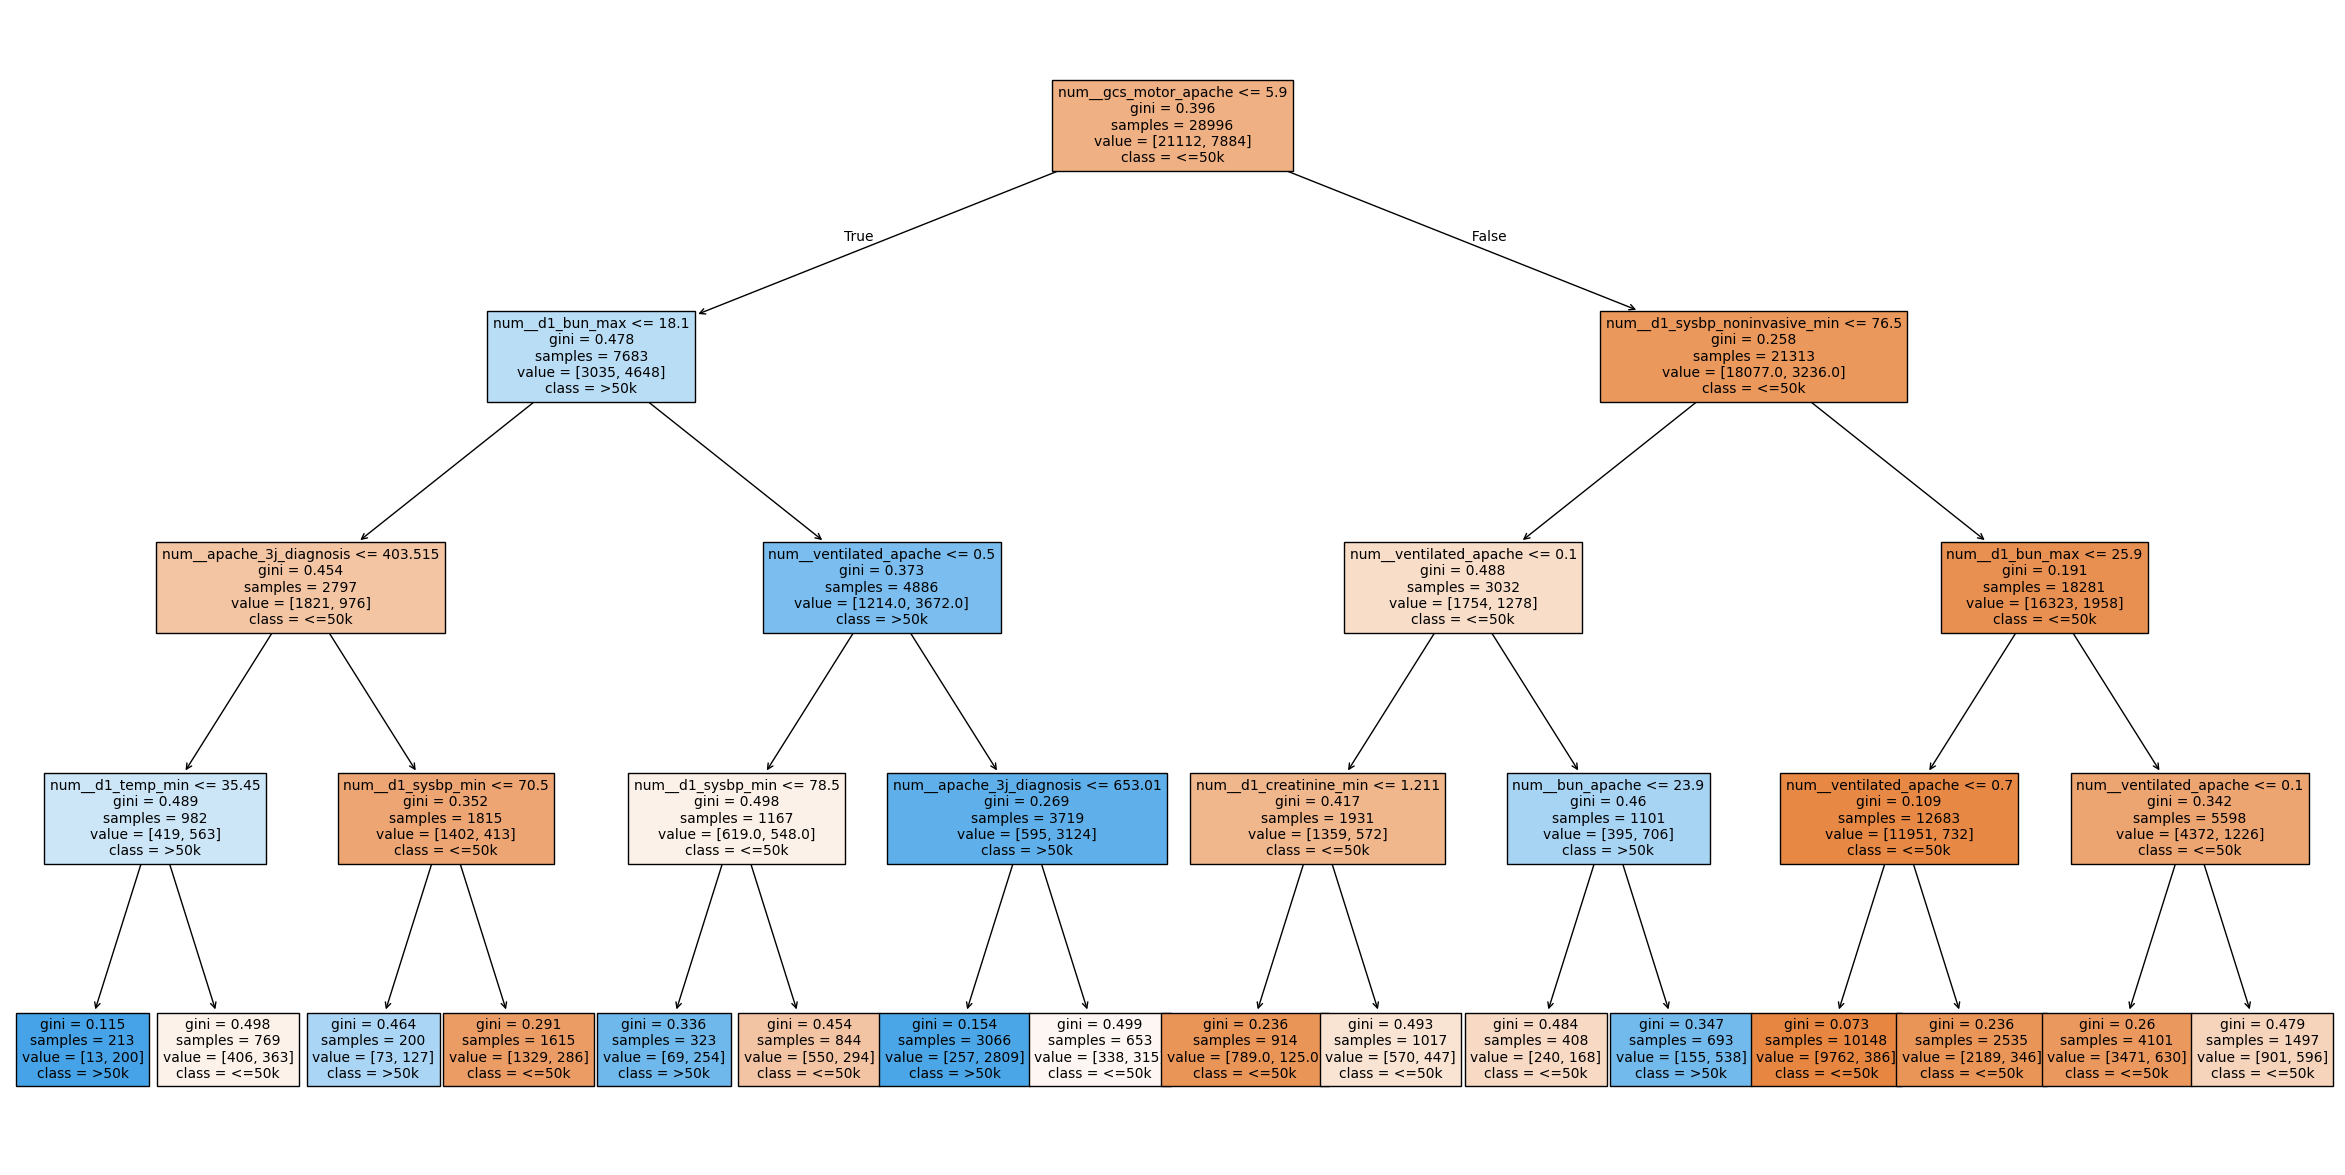

In [101]:
fig = plt.figure(figsize=(30, 15))
fig = plot_tree(
    dt,
    fontsize=10,
    feature_names=list(X_train),
    class_names=["<=50k", ">50k"],
    filled=True,
)
plt.show()

In [1]:
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import plot_tree

# This may not the best way to view each estimator as it is small
fn=[k for k,v in description_dict.items() if k != 'hospital_death']
cn=["0","1"]
# fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (10,2), dpi=900)
# plt.figure(figsize=(15, 10))
# plot_tree(rf.estimators_[0], feature_names=fn, class_names=cn, filled=True)
# plt.show()

# Extract tree sizes
num_nodes = [tree.tree_.node_count for tree in rf.estimators_]
depths = [tree.tree_.max_depth for tree in rf.estimators_]

# Print tree statistics
for i, (nodes, depth) in enumerate(zip(num_nodes, depths)):
    print(f"Tree {i}: Number of nodes = {nodes}, Depth = {depth}")

# Get average values
print(f"\nAverage tree size: {np.mean(num_nodes):.2f} nodes")
print(f"Average tree depth: {np.mean(depths):.2f}")

NameError: name 'description_dict' is not defined

In [67]:
import matplotlib.pyplot as plt

# retrieve predicted classes
print('predicted classes: {}'.format(y_pred))

# print confidence scores instead of discrete predictions
print('confidence scores: {}'.format(rf.predict_proba(X_val)))

# retrieve confidence scores for the positive class
y_score = rf.predict_proba(X_val)[:, 1]
print('confidence scores positive class: {}'.format(y_score))


predicted classes: [0 0 0 ... 0 0 0]
confidence scores: [[0.86615835 0.13384165]
 [0.92257368 0.07742632]
 [0.78787204 0.21212796]
 ...
 [0.97275625 0.02724375]
 [0.72902597 0.27097403]
 [0.96252783 0.03747217]]
confidence scores positive class: [0.13384165 0.07742632 0.21212796 ... 0.02724375 0.27097403 0.03747217]


ROC-AUC: 0.88


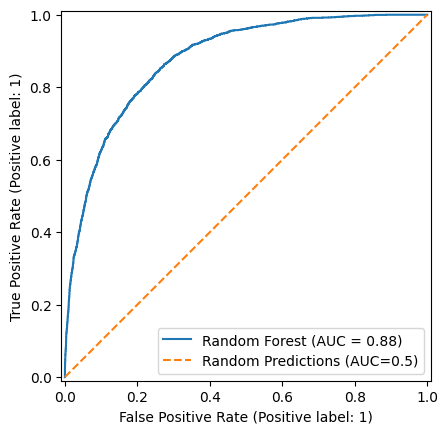

In [145]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay

# compute area under the ROC curve
roc_auc = roc_auc_score(y_true=y_val, y_score=y_score)
print('ROC-AUC: {:.2f}'.format(roc_auc))

# plot ROC curve from predictions
RocCurveDisplay.from_predictions(y_true=y_val, y_pred=y_score, name='Random Forest')
plt.plot([0, 1], [0, 1], linestyle="--", label='Random Predictions (AUC=0.5)')
plt.legend()
plt.show()

average precision: 0.67


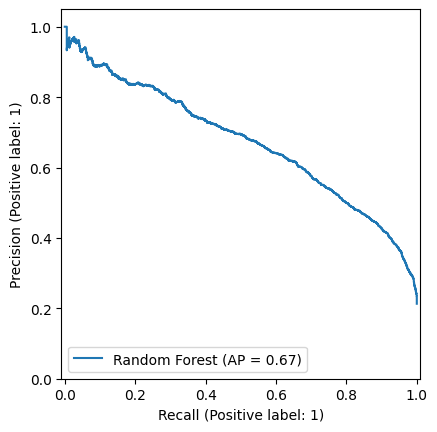

In [120]:
from sklearn.metrics import average_precision_score, PrecisionRecallDisplay

# compute average precision
avg_precision = average_precision_score(y_true=y_val, y_score=y_score)
print('average precision: {:.2f}'.format(avg_precision))

# plot precision-recall curve
PrecisionRecallDisplay.from_predictions(y_true=y_val, y_pred=y_score, name='Random Forest')
plt.ylim(0,1.05)
plt.show()

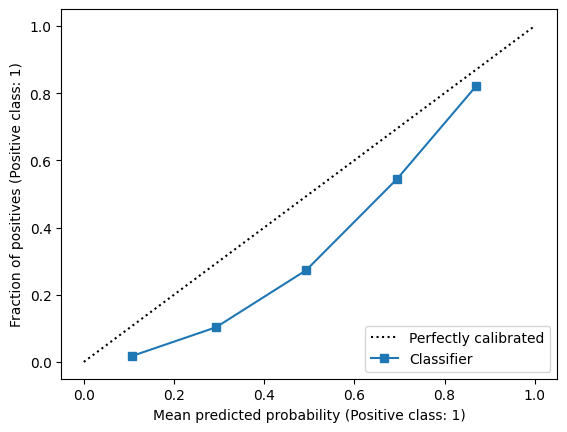

In [121]:
from sklearn.calibration import CalibrationDisplay

# plot calibration curve
disp = CalibrationDisplay.from_predictions(y_true=y_val, y_prob=y_score)
plt.show()

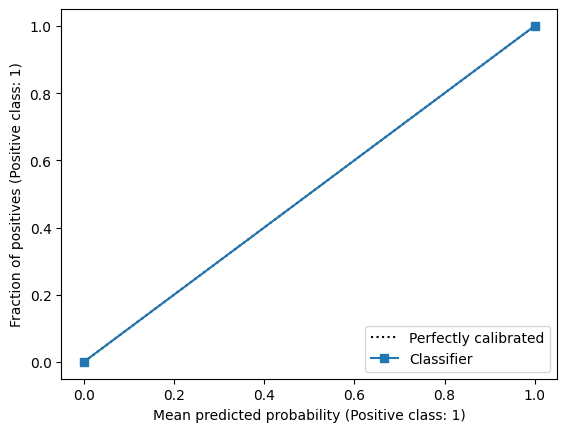

In [122]:
# plot calibration curve for classifications
disp = CalibrationDisplay.from_predictions(y_true=y_val, y_prob=y_val)
plt.show()

In [123]:
# sample three instances
sample_X = X_val.sample(n=3, random_state=0)
sample_y = y_val[sample_X.index]

# display instance, true class, and model confidence
display(sample_X)
print("True class:      %s" %list(sample_y))
print("Predicted class: %s" %[i[1] for i in rf.predict_proba(sample_X)])

,cat__ethnicity_African American,cat__ethnicity_Asian,cat__ethnicity_Caucasian,cat__ethnicity_Hispanic,cat__ethnicity_Native American,cat__ethnicity_Other/Unknown,cat__ethnicity_missing,cat__gender_F,cat__gender_M,cat__gender_missing,...,num__d1_pao2fio2ratio_max,num__d1_pao2fio2ratio_min,num__aids,num__cirrhosis,num__diabetes_mellitus,num__hepatic_failure,num__immunosuppression,num__leukemia,num__lymphoma,num__solid_tumor_with_metastasis
7166,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,234.047619,228.747619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7622,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,257.100000,182.933333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6259,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,480.000000,405.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


True class:      [np.int64(0), np.int64(0), np.int64(0)]
Predicted class: [np.float64(0.4129773669051206), np.float64(0.02048382376455317), np.float64(0.7444243075664783)]


c:\Users\20212162\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


cat__ethnicity_African American     0.0
cat__ethnicity_Asian                0.0
cat__ethnicity_Caucasian            1.0
cat__ethnicity_Hispanic             0.0
cat__ethnicity_Native American      0.0
                                   ... 
num__hepatic_failure                0.0
num__immunosuppression              0.0
num__leukemia                       0.0
num__lymphoma                       0.0
num__solid_tumor_with_metastasis    0.0
Name: 7166, Length: 185, dtype: float64

Local prediction: 0.66
Fit (Rˆ2): 0.35
Intercept: 0.66


C:\Users\20212162\AppData\Local\Temp\ipykernel_16076\3342334297.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Local prediction: %.2f" % explanation_i.local_pred)


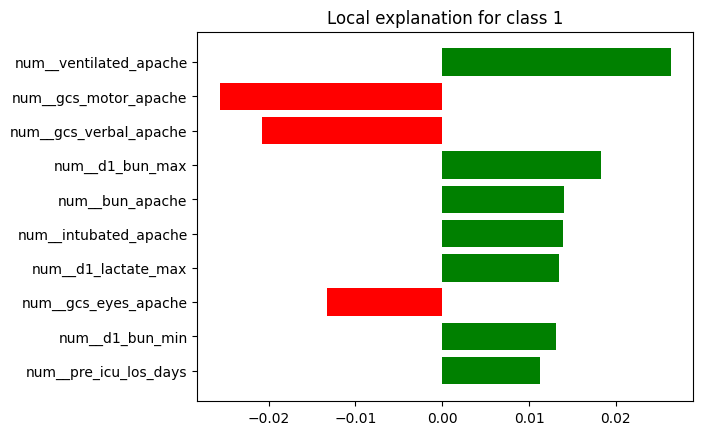

c:\Users\20212162\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


cat__ethnicity_African American     0.0
cat__ethnicity_Asian                0.0
cat__ethnicity_Caucasian            1.0
cat__ethnicity_Hispanic             0.0
cat__ethnicity_Native American      0.0
                                   ... 
num__hepatic_failure                0.0
num__immunosuppression              0.0
num__leukemia                       0.0
num__lymphoma                       0.0
num__solid_tumor_with_metastasis    0.0
Name: 7622, Length: 185, dtype: float64

Local prediction: 0.57
Fit (Rˆ2): 0.35
Intercept: 0.66


C:\Users\20212162\AppData\Local\Temp\ipykernel_16076\3342334297.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Local prediction: %.2f" % explanation_i.local_pred)


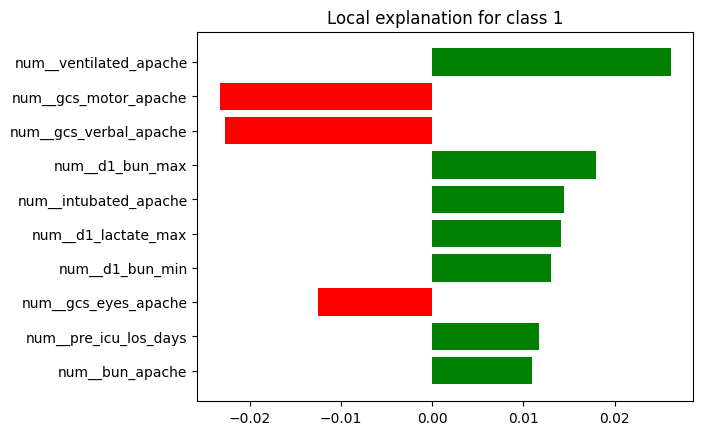

c:\Users\20212162\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


cat__ethnicity_African American     0.0
cat__ethnicity_Asian                0.0
cat__ethnicity_Caucasian            1.0
cat__ethnicity_Hispanic             0.0
cat__ethnicity_Native American      0.0
                                   ... 
num__hepatic_failure                0.0
num__immunosuppression              0.0
num__leukemia                       0.0
num__lymphoma                       0.0
num__solid_tumor_with_metastasis    0.0
Name: 6259, Length: 185, dtype: float64

Local prediction: 0.89
Fit (Rˆ2): 0.37
Intercept: 0.66


C:\Users\20212162\AppData\Local\Temp\ipykernel_16076\3342334297.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Local prediction: %.2f" % explanation_i.local_pred)


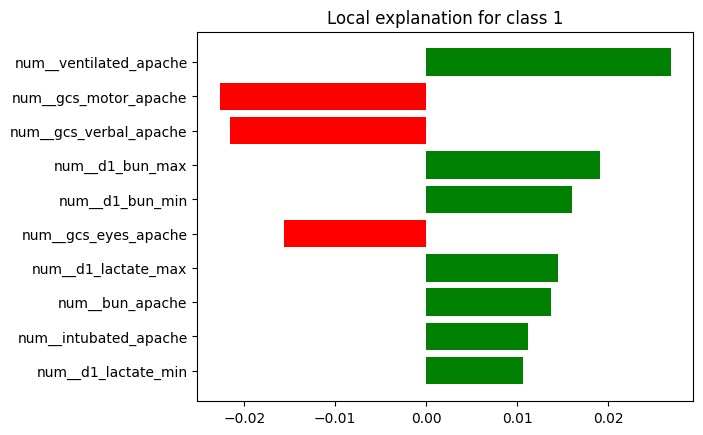

In [126]:
# define lime explainer
lime_explainer = LimeTabularExplainer(
    X_train,
    mode="classification",
    feature_names=list(X_train),
    kernel_width=np.sqrt(len(X_train)),
    discretize_continuous=False,
    feature_selection="forward_selection",
)

# explain the three instances
for i in range(3):
    explanation_i = lime_explainer.explain_instance(
        sample_X.iloc[i],
        rf.predict_proba,
        num_features=10,
        num_samples=5000,
        distance_metric="euclidean",
    )
    display(sample_X.iloc[i])
    print("Local prediction: %.2f" % explanation_i.local_pred)
    print("Fit (Rˆ2): %.2f" % explanation_i.score)
    print("Intercept: %.2f" % explanation_i.intercept[1])
    explanation_i.as_pyplot_figure()
    plt.show()

In [127]:
shap_explainer = Explainer(rf, X_train, algorithm="tree")
shap_values = shap_explainer(sample_X)

Base value: 0.31


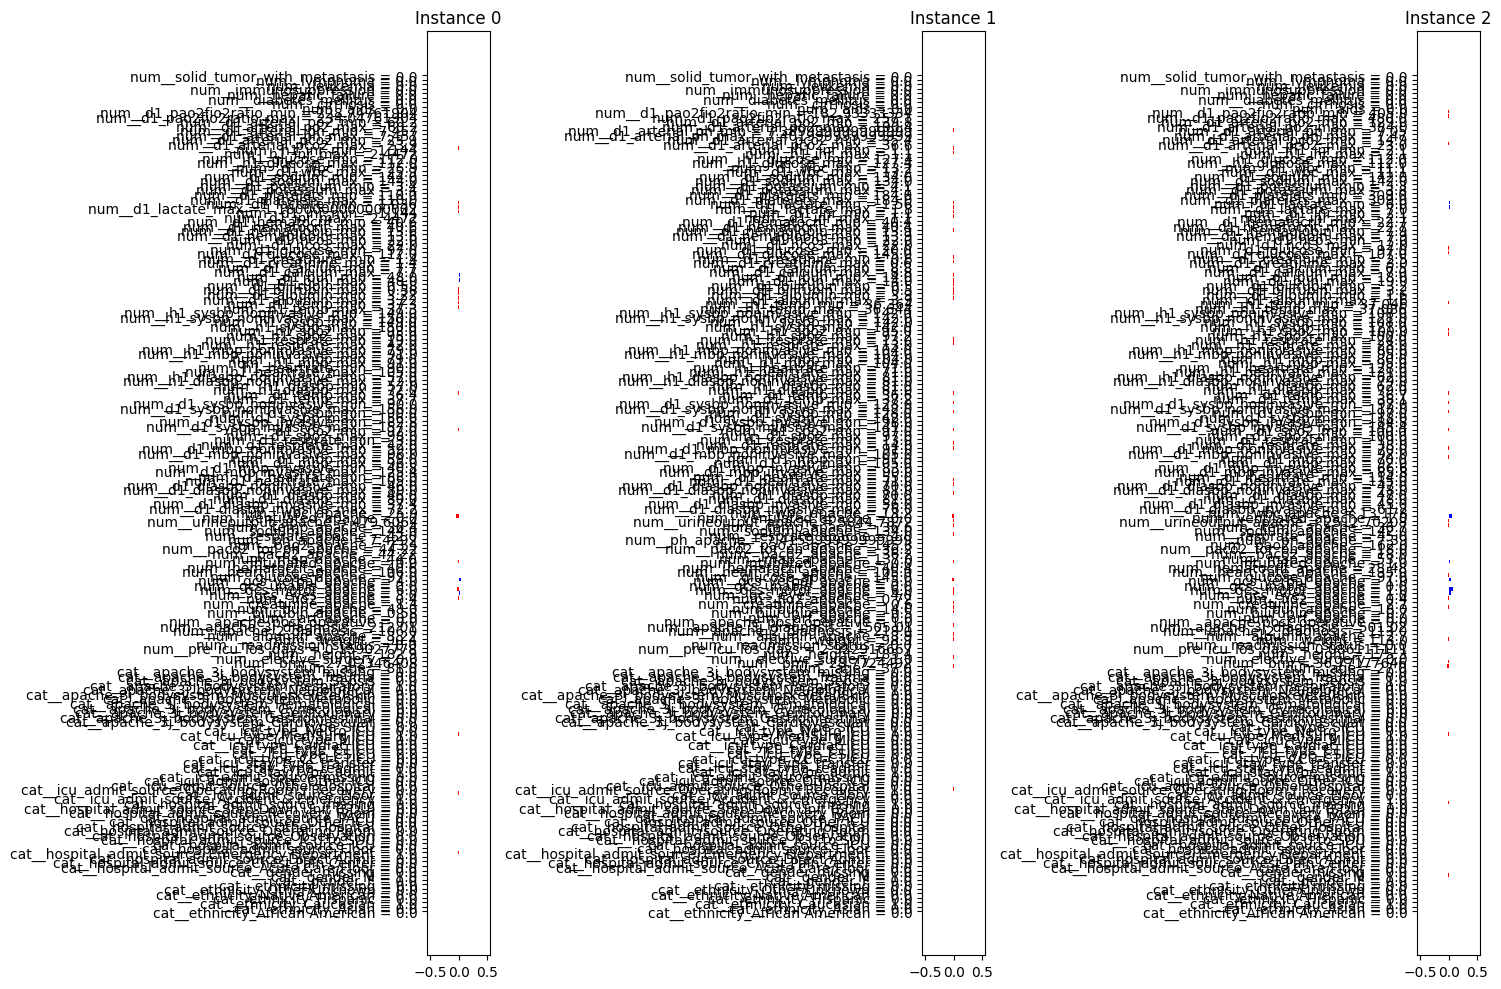

In [141]:
# compute base value which we can compare against
print("Base value: %.2f" % shap_values.base_values[0][1])

# plot shap values
feature_names = list(X_train)
fig, ax = fig, ax = plt.subplots(1, 3, figsize=(15, 10))
for i in range(3):
    # get values for instance
    feature_values_i = shap_values.data[i]
    shap_values_i = [i[1] for i in shap_values[i].values]
    feature_labels_i = [
        "%s = %s" % (name, value)
        for name, value in zip(feature_names, feature_values_i)
    ]
    # plot instance
    ax[i].barh(
        feature_labels_i,
        shap_values_i,
        color=["b" if i >= 0 else "r" for i in np.sign(shap_values_i)],
    )
    ax[i].set_title("Instance %s" % i)
    ax[i].set_xlim(-0.55, 0.55)
plt.tight_layout()
plt.savefig("Shap.png")
plt.show()

In [129]:
print("Instance 1")
print("average prediction:  %.2f" % shap_values.base_values[1][1])
print("sum(SHAP values):    %.2f" % np.sum([i[1] for i in shap_values.values[1]]))
print("model prediction:    %.2f" % rf.predict_proba([sample_X.iloc[1]])[0][1])

Instance 1
average prediction:  0.31
sum(SHAP values):    -0.29
model prediction:    0.02


c:\Users\20212162\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
